<a href="https://colab.research.google.com/github/alexlinapp/python_tools_practice/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from fastai.vision.all import *
from torchinfo import summary
print(torch.__version__)

2.6.0+cu124


In [3]:
transform = transforms.ToTensor()

# Download and load MNIST training data
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Download and load MNIST test data
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.24MB/s]


In [4]:
dls = DataLoader(mnist_train, batch_size=64, shuffle=True)
xb, yb = next(iter(dls))
xb = xb.view(64, -1, 28, 28)
xb.shape, yb.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

<Axes: >

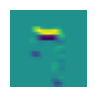

In [5]:
top_edge = torch.tensor([[-1,-1,-1], [0,0,0], [1,1,1]]).float()
bottom_edge = torch.tensor([[1,1,1], [0,0,0], [-1,-1,-1]]).float()
edge_kernels = torch.stack([top_edge, bottom_edge]).unsqueeze(1)
#show_image(xb[59].view(-1, 28))
batch_features = F.conv2d(xb.view(-1, 1, 28, 28), edge_kernels, stride=1, padding=1)
show_image(batch_features[59][0])

In [6]:
broken_cnn = sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3, padding=1)
)
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [7]:
def conv(ni, nf, ks=3, act=True):
  res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
  if act: res = nn.Sequential(res, nn.ReLU())
  return res

In [15]:
simple_cnn = sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,10, act=False), #1x1
    Flatten(),
)
simple_cnn(xb).shape
summary(simple_cnn, input_size=(64, 1, 28, 28))#, simple_cnn(xb).shape

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 10]                  --
├─Sequential: 1-1                        [64, 4, 14, 14]           --
│    └─Conv2d: 2-1                       [64, 4, 14, 14]           40
│    └─ReLU: 2-2                         [64, 4, 14, 14]           --
├─Sequential: 1-2                        [64, 8, 7, 7]             --
│    └─Conv2d: 2-3                       [64, 8, 7, 7]             296
│    └─ReLU: 2-4                         [64, 8, 7, 7]             --
├─Sequential: 1-3                        [64, 16, 4, 4]            --
│    └─Conv2d: 2-5                       [64, 16, 4, 4]            1,168
│    └─ReLU: 2-6                         [64, 16, 4, 4]            --
├─Sequential: 1-4                        [64, 32, 2, 2]            --
│    └─Conv2d: 2-7                       [64, 32, 2, 2]            4,640
│    └─ReLU: 2-8                         [64, 32, 2, 2]            --
├─Conv2d

In [20]:
def train_model(model, optimizer, epochs=4, device="cpu"):
  model.to(device)
  model.train()
  for epoch in range(epochs):
    train_loss = 0
    correct = 0
    for xb, yb in DataLoader(mnist_train, batch_size=64, shuffle=True):
      optimizer.zero_grad()
      xb = xb.to(device)
      yb = yb.to(device)
      preds = model(xb)
      loss = F.cross_entropy(preds, yb)
      loss.backward()
      optimizer.step()
      correct += (preds.argmax(dim=1) == yb).sum().item()
      train_loss += loss.item() * xb.size(0)
    train_loss /= len(mnist_train)
    train_acc = correct / len(mnist_train)
    print(f"Epoch {epoch+1}: Train loss {train_loss:.4f}, Train accuracy {train_acc:.4f}")



def validate_model(model, epochs = 1, device="cpu"):
  model.to(device)
  model.eval()
  for epoch in range(epochs):
    correct = 0
    val_loss = 0
    with torch.no_grad():
      for xb, yb in DataLoader(mnist_test, batch_size=64, shuffle=True):
        xb = xb.to(device)
        yb = yb.to(device)
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        val_loss += loss.item() * xb.size(0)
        correct += (preds.argmax(dim=1) == yb).sum().item()
    val_acc = correct / len(mnist_test)
    val_loss /= len(mnist_test)
    print(f"Epoch {epoch+1}: Val loss {val_loss:.4f}, Val accuracy {val_acc:.4f}")



def train_and_validate(model, optimizer, epochs=4, device="cpu"):
  model.to(device)
  model.train()
  for epoch in range(epochs):
    train_loss = 0
    train_correct = 0
    for xb, yb in DataLoader(mnist_train, batch_size=64, shuffle=True):
      optimizer.zero_grad()
      xb = xb.to(device)
      yb = yb.to(device)
      preds = model(xb)
      loss = F.cross_entropy(preds, yb)
      loss.backward()
      optimizer.step()
      train_correct += (preds.argmax(dim=1) == yb).sum().item()
      train_loss += loss.item() * xb.size(0)
    train_loss /= len(mnist_train)
    train_acc = train_correct / len(mnist_train)
    print(f"Epoch {epoch+1}: Train loss {train_loss:.4f}, Train accuracy {train_acc:.4f}")
    val_correct = 0
    val_loss = 0
    with torch.no_grad():
      for xb, yb in DataLoader(mnist_test, batch_size=64, shuffle=True):
        xb = xb.to(device)
        yb = yb.to(device)
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        val_loss += loss.item() * xb.size(0)
        val_correct += (preds.argmax(dim=1) == yb).sum().item()
    val_acc = val_correct / len(mnist_test)
    val_loss /= len(mnist_test)
    print(f"Epoch {epoch+1}: Val loss {val_loss:.4f}, Val accuracy {val_acc:.4f}")


In [21]:
#train_model(simple_cnn, torch.optim.Adam(simple_cnn.parameters(), lr=0.01), epochs=5, device="cuda")
#validate_model(simple_cnn, epochs=5, device="cuda")
train_and_validate(simple_cnn, torch.optim.Adam(simple_cnn.parameters(), lr=0.01), epochs=5, device="cuda")

Epoch 1: Train loss 0.0770, Train accuracy 0.9770
Epoch 1: Val loss 0.0876, Val accuracy 0.9770
Epoch 2: Train loss 0.0786, Train accuracy 0.9772
Epoch 2: Val loss 0.1103, Val accuracy 0.9682
Epoch 3: Train loss 0.0815, Train accuracy 0.9748
Epoch 3: Val loss 0.0947, Val accuracy 0.9712
Epoch 4: Train loss 0.0772, Train accuracy 0.9773
Epoch 4: Val loss 0.0861, Val accuracy 0.9747
Epoch 5: Train loss 0.0755, Train accuracy 0.9778
Epoch 5: Val loss 0.0908, Val accuracy 0.9759
